# Week 4 - Evaluation Metrics for Classification Models

## 4.1 - Preparation

We are going to be using a similar approach to last week to get the model running so this section is primarily copy and pasted.

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
#get data
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
!wget $data -O data.csv

--2023-10-04 08:00:27--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 954.59K  --.-KB/s    in 0.1s    

2023-10-04 08:00:27 (7.83 MB/s) - ‘data.csv’ saved [977501/977501]



In [3]:
df = pd.read_csv('data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

The model is 80% accurate.

## 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check thea ccuracy of dummy baselines

In [8]:
#check # of customers
len(y_val)

1409

In [9]:
#check # correctly predicted
(y_val == churn_decision).sum()

1132

In [10]:
#divide to get accuracy, the same as the mean we've done previously
1132/1409

0.8034066713981547

But remember we chose the decision threshold as 0.5, now we need to see if that was a good idea

In [11]:
#example threshold evaluation
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    #grab these 2 lines from the model above
    churn_decision = (y_pred >= t) #use t instead of 0.5
    score = (y_val == churn_decision).mean() #record accuracy as score
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


The accuracy was actually the highest at the 0.5 threshold we chose

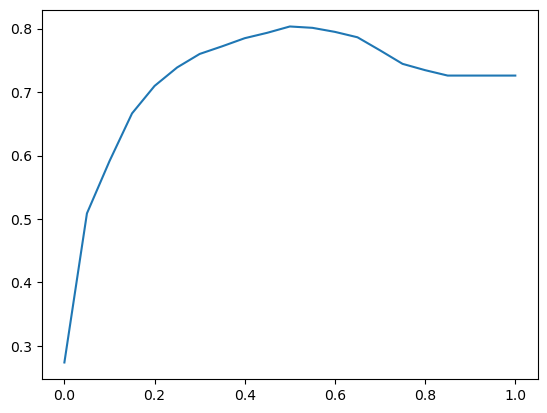

In [12]:
plt.plot(thresholds,scores)

There is a function that can do this already in scikit learn

In [13]:
#import package
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5) #2 metrics, actual then predictions

0.8034066713981547

In [15]:
#simplify previous function
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [16]:
from collections import Counter

In [17]:
Counter(y_val), 1- y_val.mean()

(Counter({0: 1023, 1: 386}), 0.7260468417317246)

Notice that in our dataset 72% of customers do not churn. Our model is 80% accurate which means only a 7% difference in accuracy from if we just predicted no customers would churn...

This is because there is an imabalance of ~3:1 non-churn to churn in our dataset. This is why accuracy can be very misleading. In the next lesson we will look at ways to handle this situation

## 4.3 Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [28]:
#true positive
#output will be true if both are true
tp = (predict_positive & actual_positive).sum()
#true negative
tn = (predict_negative & actual_negative).sum()
#false positive
fp = (predict_positive & actual_negative).sum()
#false negative
fn = (predict_negative & actual_positive).sum()

In [32]:
f"true positive {tp}", f"true negative {tn}", f"false positive {fp}", f"false negative {fn}"

('true positive 210',
 'true negative 922',
 'false positive 101',
 'false negative 176')

In [35]:
#creating the confusion table with numpy
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

101 customers received a promotional discount email without needing  
176 customers churned without receiving a promotional discount email

In [38]:
#can normalize as well to get percentages
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

You can see our accuracy here by summing the true negative and true positive (65% + 15%)

4 numbers provide much more granular explanation of the model's decisions compared to the original accuracy calculation we used

## 4.4 Precision and Recall

In [40]:
#calculating accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.8034066713981547

Precision: fraction of positive predictions that are correct  
Precision only cares when g(x) >= t

In [43]:
#calculating precision
p = (tp) / (tp + fp)
p

0.6752411575562701

~33% of customers are getting the promotional email when they shouldn't

Recall: fraction of correctly identified positive examples  
Recall only cares when y = 1

In [44]:
#calculating recall
r = (tp) / (tp + fn)
r

0.5440414507772021

Failed to identify ~45% of churning customers

We can see our 80% accuracy model is actually not a great model when you factor in precision and recall

This is particularly useful when there is class imbalance

## 4.5 ROC Curves
TPR and FPR

TPR is the same as recall:  
TPR = recall = (tp) / (tp + fn)  

FPR is interested in false positives compared to total number of negatives:  
FPR = (fp) / (tn + fp)

In FPR we want it to be as small as possible so small FP and large TN  
In TPR we want it to be as large as possible so large TP and small FN

In [45]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [46]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [51]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    
    #first create confusion table
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    #replacing hard coded t with thresholds
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    #add values
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp,tn,fp,fn))

In [57]:
columns = ['threshold','tp','tn','fp','fn']
df_scores = pd.DataFrame(scores, columns=columns)

In [58]:
#add tpr and fpr
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [59]:
#checking every 10th value
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


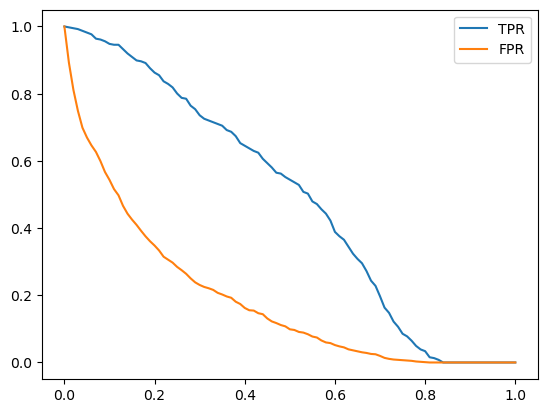

In [61]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

We want to minimize the FPR and maximize the TPR

### Random Model
We are going to create a random model as a baseline so for each customer the churn decision is completely random

In [64]:
#generate random predictions
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [65]:
#check accuracy
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

Accuracy is ~50% as we would expect

In [67]:
#turning our previous code above into a single function to easily pass values
def tpr_fpr_dataframe(y_val, y_pred):

    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        
        #first create confusion table
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        #replacing hard coded t with thresholds
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        #add values
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t,tp,tn,fp,fn))

    columns = ['threshold','tp','tn','fp','fn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [70]:
#run the function with the random predictions
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [69]:
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


Note that the random model the TPR and FPR are both a linear decreasing line from top left to bottom right unlike the curves above

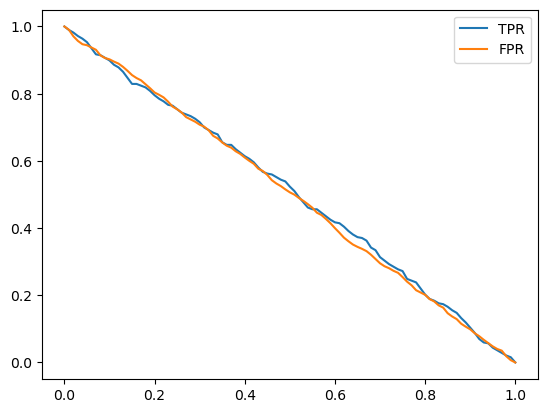

In [71]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend()

Now for a different benchmark

### Ideal model

Ideal model orders the customers lowest to highest from no churn to churn 0.01 to 0.99 for example  
Then pick the threshold to achieve 100% accuracy

In [72]:
#get num of each
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [74]:
#repeast 1st element of list (0) num_neg times and 2nd element of list (1) num_pos times
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [76]:
#create predictions
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [80]:
thresh = 1 - y_val.mean()
thresh

0.7260468417317246

In [79]:
((y_ideal_pred >= thresh) == y_ideal).mean()

1.0

Now it predicts 100% accuracy  
While this ideal model does not exist in practice it is good for benchmarking

In [81]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.00,386,0,1023,0,1.000000,1.000000
1,0.01,386,15,1008,0,1.000000,0.985337
2,0.02,386,29,994,0,1.000000,0.971652
3,0.03,386,43,980,0,1.000000,0.957967
4,0.04,386,57,966,0,1.000000,0.944282
...,...,...,...,...,...,...,...
96,0.96,57,1023,0,329,0.147668,0.000000
97,0.97,43,1023,0,343,0.111399,0.000000
98,0.98,29,1023,0,357,0.075130,0.000000
99,0.99,15,1023,0,371,0.038860,0.000000


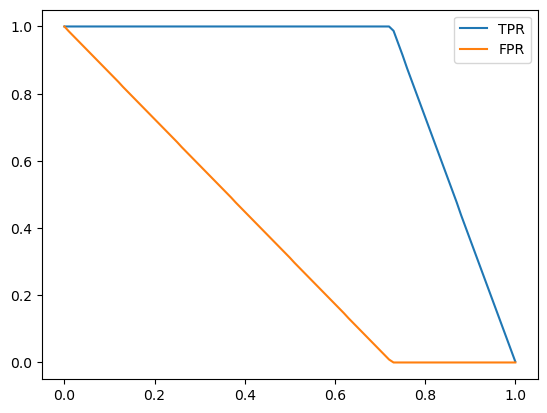

In [82]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend()

### Plotting everything together

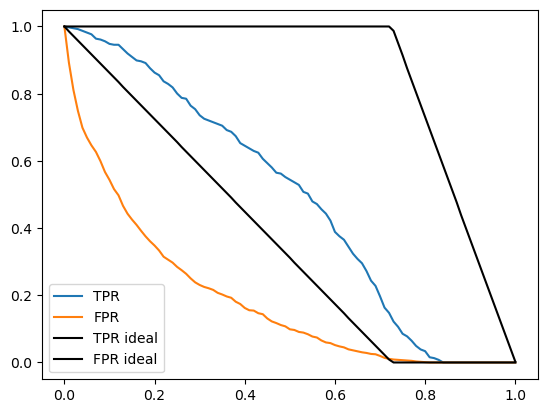

In [85]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR ideal', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR ideal', color = 'black')

plt.legend()

Our true positive is seen to be very far away from the ideal model meaning we are making many mistakes

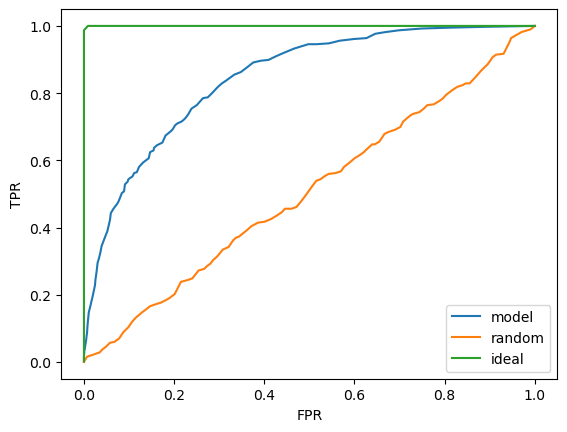

In [94]:
#plot fpr vs tpr of our model
plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
#do the same for benchmarks
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

Calculating the area under the curve or ROC AUC is a great identifier of how successful the model is

### TPR and FPR with SKLearn

In [95]:
from sklearn.metrics import roc_curve

In [99]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

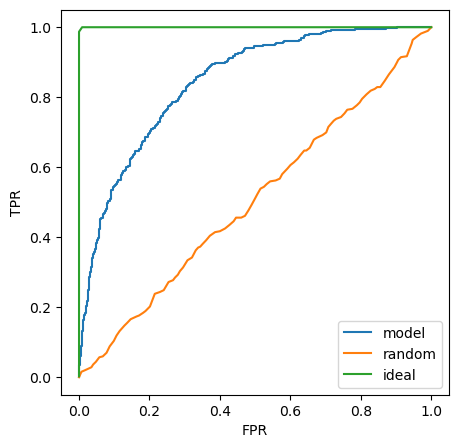

In [102]:
#make plot a square
plt.figure(figsize = (5,5))

#plot fpr vs tpr of our model
plt.plot(fpr, tpr, label = 'model')
#do the same for benchmarks
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [103]:
#note this package can be used to calculate area under any curve not just roc
from sklearn.metrics import auc

In [104]:
#compute area under the curve
auc(fpr, tpr)

0.843850505725819

In [106]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [108]:
#another method
from sklearn.metrics import roc_auc_score

In [109]:
roc_auc_score(y_val, y_pred)

0.843850505725819

Say we split all our negative and positive records and grabbed them 1 by 1 each and checked if the randomly selected positive had a higher value than the randomly selected negative. This probability is what the area under the curve is calculating  
P({random pos example} > {random neg example})

In [110]:
#get all neg scores
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [111]:
import random

In [112]:
#randomly select

#set how many iterations
n = 10000

success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]: #count how many times it was true
        success = success + 1

success / n #calculate the %

0.8388

Note it is very close to the AUC calculated previously

In [118]:
#this can also be done automatically with numpy in a vectorized way
n=50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [117]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.84396